In [1]:
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

rng = np.random.default_rng(444)

What do I want to do here? Adding more strategies lowers the fixed point but makes things less stable.  Adding memory seems to push attendance toward the middle.  Making the strategies more heterogeneous will make things more stable.  So potentially

1. If attendance is too volatile, make strategies more heterogeneous.
2. If attendance is too high and stable add more strategies.
3. If attendance is too low and below 50% and stable, add more memory.
4. If attendance is above 50% and too low and stable, reduce memory.


Simpler version:

If an agent is not happy with their attendance, they randomly pick new s, m and regenerate all their strategies.  Could this be enough?

In [2]:
rng.choice(2)

1

In [3]:
def make_uniform_strategies(rng, strategies, memory):
    return rng.uniform(-1,1, size=(strategies, memory))


def minimize_squared_error(rng,predictions,observations,threshold,strategies):
        # calculate the absolute error of predictions
        # here, we discard the rightmost prediction as
        # this is the prediction for the future.
        # if we knew the correct answer for that,
        # we wouldn't need to predict it!
        errs = ((predictions - observations)**2).sum(axis=1)

        return np.argmin(errs)

    
def make_centered_strategies(rng, strategies, memory):
    return rng.uniform(-1,1, size=(strategies, memory)) + 1/memory


def pick_optimal_choices(rng,predictions,observations,threshold,strategies):
    # how often does each predictor match the desired outcome?
    performances = np.tile(observations < threshold, (strategies, 1)) == (predictions < threshold)
    
    # add noise to randomize tie breaker
    scores = rng.uniform(0,0.1, size=strategies) + performances.sum(axis=1)
    return np.argmax(scores)


In [4]:
class EFBPSim:
    def __init__(
        self,
        agents = 100, # number of agents
        threshold = 60, # threshold for attendance
        strategies = 10, # number of strategies
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 8,
        # number of rounds to run the simulation
        n_iter = 500,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # alternately, caller may pass a new strategy function
        strategy_func=None,
        # function for selecting the best strategy
        best_strat_func=minimize_squared_error,
        # starting history
        start=None,
        # file to write attendance history as it is generated
        writefile=None,
        # random seed for numpy
        seed=23
    ):
        
        rng = np.random.default_rng(seed)

        # each row is a strategy
        if not strategy_func:
            if distribution=="unbiased":
                strategy_func =  make_unbiased_strategies
            elif distribution=="uniform":
                strategy_func = make_uniform_strategies

        # shape is (agents, strategies,memory)
        strats = {
            memory: np.stack([
            strategy_func(rng, strategies, memory) for _ in range(agents)
        ])}

        agent_indices = {
            memory: [(i*strategies, (i+1) * strategies) for i in range(agents)]
        }

        if start is None:
            start = rng.choice(agents, size=(memory*2))

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)
            
        agent_went = {
            memory: np.zeros((agents, len(hist)))
        }
            
        # index of week
        # we need some starting history to begin making selections
        t = memory * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = {
            memory: np.zeros((agents, len(hist)), dtype=int)
        }

        # set up the predictions for initial history
        windows = np.vstack([
            hist[t-2*memory+i: t-memory + i]
            for i in range(memory)
        ])

        pred_history = {
            memory: np.zeros((agents, strategies, len(hist)))
        }
            
        pred_history[memory][:, :, memory:2*memory] = strats[memory].dot(windows)

        best_preds = {
            memory:np.zeros(agents)
        }

        while t < memory * 2 + n_iter:
            for m in strats.keys():
                window = hist[t-m:t]
                pred_history[m][:,:, t] = strats[m].dot(window)

                for agent in range(agents):
                    strat = strats[m][agent]

                    predictions = pred_history[m][agent, :, t-m:t]
                    observations = hist[t-m:t]
                    best_strat = best_strat_func(rng, predictions, observations, threshold, strategies)
                    best_strats[memory][agent, t] = best_strat
                    best_preds[memory][agent] = pred_history[m][agent, best_strat, t]

                hist[t] += (best_preds[m] < threshold).sum()

            if writefile:
                with open(writefile, "a") as f:
                    f.write(str(hist[t]) + ",")
            
            # stop the simulation if it reaches a stable cycle
            # it seems like these are generally of period 3 so just
            # look for those
            """
            if best_strat_func==minimize_squared_error and t >= 2*memory + 6:
                if (hist[t-2:t+1] == hist[t-5:t-2]).all():
                    hist = hist[:t+1]
                    break
            """

            t += 1
    
        self.t = t
        self.hist = hist[2*memory:t]
        """
        self.best_strats = {
            m: bs[:, 2*memory:t]
            for m, bs in best_strats.items()
        }
        self.pred_history = {
            m: ph[:,:, 2*memory:t]
            for m, ph in pred_history.items()
        }
        """
        self.best_strats = best_strats
        self.pred_history = pred_history
        self.strats = strats
        
    def first_a(self):
        return [self.strats[i][int(s), 0] for i, s in enumerate(self.best_strats)]
    
    def jth_a(self, j):
        return [self.strats[i][int(s), j] for i, s in enumerate(self.best_strats)]

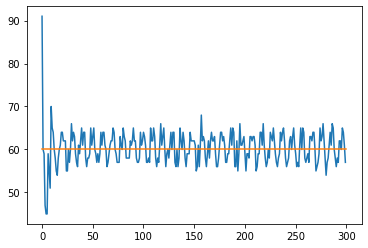

In [5]:
agents = 100
strategies = 5
memory = 8
threshold=60
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

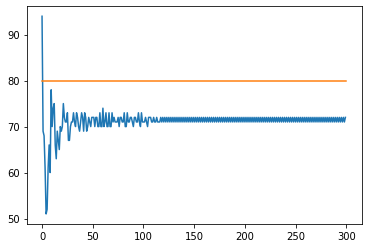

In [6]:
agents = 100
strategies = 5
memory = 8
threshold=80
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

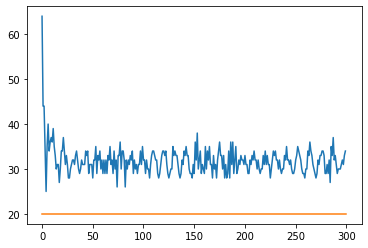

In [7]:
agents = 100
strategies = 5
memory = 8
threshold=20
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

This version is reproducing the original.  Now let's give it options!

In [8]:
class EFBPSim:
    def __init__(
        self,
        agents = 100, # number of agents
        threshold = 60, # threshold for attendance
        strategies = 10, # number of strategies
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 8,
        # number of rounds to run the simulation
        n_iter = 500,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # alternately, caller may pass a new strategy function
        strategy_func=None,
        # function for selecting the best strategy
        best_strat_func=minimize_squared_error,
        # starting history
        start=None,
        # file to write attendance history as it is generated
        writefile=None,
        # random seed for numpy
        seed=23
    ):
        
        rng = np.random.default_rng(seed)

        # each row is a strategy
        if not strategy_func:
            if distribution=="unbiased":
                strategy_func =  make_unbiased_strategies
            elif distribution=="uniform":
                strategy_func = make_uniform_strategies

        # shape is (agents, strategies,memory)
        strats = {
            memory: strategy_func(rng, strategies*agents, memory)
        }

        agent_indices = {
            memory: [(i*strategies, (i+1) * strategies) for i in range(agents)]
        }

        if start is None:
            start = rng.choice(agents, size=(memory*2))

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)
            
        agent_went = {
            memory: np.zeros((agents, len(hist)))
        }
            
        # index of week
        # we need some starting history to begin making selections
        t = memory * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = {
            memory: np.zeros((agents, len(hist)), dtype=int)
        }

        # set up the predictions for initial history
        windows = np.vstack([
            hist[t-2*memory+i: t-memory + i]
            for i in range(memory)
        ])

        pred_history = {
            memory: np.zeros((agents * strategies, len(hist)))
        }
            
        pred_history[memory][:, memory:2*memory] = strats[memory].dot(windows)

        best_preds = {
            memory:np.zeros(agents)
        }

        while t < memory * 2 + n_iter:
            for m in strats.keys():
                window = hist[t-m:t]
                pred_history[m][:,t] = strats[m].dot(window)

                for agent, (i,j) in enumerate(agent_indices[m]):
                    strat = strats[m][i:j]

                    predictions = pred_history[m][i:j,t-m:t]
                    observations = hist[t-m:t]
                    best_strat = best_strat_func(rng, predictions, observations, threshold, strategies)
                    best_strats[memory][agent, t] = best_strat
                    best_preds[memory][agent] = pred_history[m][i + best_strat, t]

                hist[t] += (best_preds[m] < threshold).sum()

            if writefile:
                with open(writefile, "a") as f:
                    f.write(str(hist[t]) + ",")
            
            # stop the simulation if it reaches a stable cycle
            # it seems like these are generally of period 3 so just
            # look for those
            """
            if best_strat_func==minimize_squared_error and t >= 2*memory + 6:
                if (hist[t-2:t+1] == hist[t-5:t-2]).all():
                    hist = hist[:t+1]
                    break
            """

            t += 1
    
        self.t = t
        self.hist = hist[2*memory:t]
        """
        self.best_strats = {
            m: bs[:, 2*memory:t]
            for m, bs in best_strats.items()
        }
        self.pred_history = {
            m: ph[:,:, 2*memory:t]
            for m, ph in pred_history.items()
        }
        """
        self.best_strats = best_strats
        self.pred_history = pred_history
        self.strats = strats
        
    def first_a(self):
        return [self.strats[i][int(s), 0] for i, s in enumerate(self.best_strats)]
    
    def jth_a(self, j):
        return [self.strats[i][int(s), j] for i, s in enumerate(self.best_strats)]

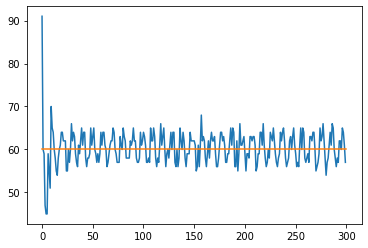

In [9]:
agents = 100
strategies = 5
memory = 8
threshold=60
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

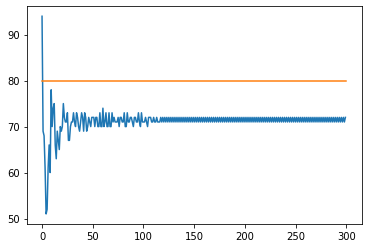

In [10]:
agents = 100
strategies = 5
memory = 8
threshold=80
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

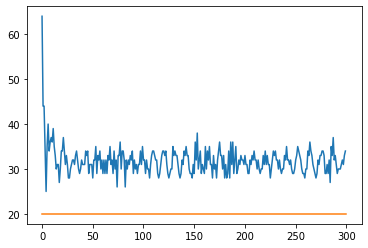

In [11]:
agents = 100
strategies = 5
memory = 8
threshold=20
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

Whoo!  Switched up the indexing.  Now let's track happiness.

In [17]:
class EFBPSim:
    def __init__(
        self,
        agents = 100, # number of agents
        threshold = 60, # threshold for attendance
        strategies = 10, # number of strategies
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 8,
        m_min=2,
        m_max=20,
        s_min=2,
        s_max=20,
        tol_rate = 0.5,
        tol_window=10,
        # number of rounds to run the simulation
        n_iter = 500,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # alternately, caller may pass a new strategy function
        strategy_func=None,
        # function for selecting the best strategy
        best_strat_func=minimize_squared_error,
        # starting history
        start=None,
        # file to write attendance history as it is generated
        writefile=None,
        # random seed for numpy
        seed=23
    ):
        
        rng = np.random.default_rng(seed)

        # each row is a strategy
        if not strategy_func:
            if distribution=="unbiased":
                strategy_func =  make_unbiased_strategies
            elif distribution=="uniform":
                strategy_func = make_uniform_strategies

        # shape is (agents, strategies,memory)
        strats = {
            memory: strategy_func(rng, strategies*agents, memory)
        }

        agent_indices = {
            memory: np.array([[i*strategies, (i+1) * strategies] for i in range(agents)])
        }

        if start is None:
            start = rng.choice(agents, size=(memory*2))

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)
            
        agent_went = {
            memory: np.zeros((agents, len(hist)))
        }
            
        # index of week
        # we need some starting history to begin making selections
        t = memory * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = {
            memory: np.zeros((agents, len(hist)), dtype=int)
        }

        # set up the predictions for initial history
        windows = np.vstack([
            hist[t-2*memory+i: t-memory + i]
            for i in range(memory)
        ])

        pred_history = {
            memory: np.zeros((agents * strategies, len(hist)))
        }
            
        pred_history[memory][:, memory:2*memory] = strats[memory].dot(windows)

        best_preds = {
            memory:np.zeros((agents, len(hist)))
        }

        while t < memory * 2 + n_iter:
            
            for m in strats.keys():
                window = hist[t-m:t]
                
                try:
                    pred_history[m][:,t] = strats[m].dot(window)
                    
                except Exception as E:
                    assert False

                for agent, [i,j] in enumerate(agent_indices[m]):                    
                    strat = strats[m][i:j]

                    predictions = pred_history[m][i:j,t-m:t]
                    observations = hist[t-m:t]
                    
                    mask = ~np.isnan(predictions)
                    
                    # sanity check that all rows have same values
                    try:
                        assert (mask.any(axis=0) == mask.all(axis=0)).all()
                    except Exception as e:
                        print(i)
                        print(j)
                        print(predictions)
                        print(m)
                        print(mask)
                        raise e
                    
                    if (mask==False).all():
                        best_strat = 0
                    else:
                        # find first week with valid predictions
                        start_col = np.where(mask)[1][0]
                        best_strat = best_strat_func(rng, predictions[:, start_col:], observations[start_col:], threshold, j - i)
                        
                    best_strats[m][agent, t] = best_strat
                    best_preds[m][agent, t] = pred_history[m][i + best_strat, t]

                hist[t] += (best_preds[m] [:,t] < threshold).sum()
                
                
            # go back through and evaluate if the agent needs
            # to change parameters once we know the last attendance value
            ms = list(strats.keys())
            for m in ms:
                if t < 2 * memory + tol_window :
                    continue
                    
                optimal_choices = hist[t-tol_window:t] < threshold
                
                # iterate through agents in reverse order
                # so enumeration doesn't get messed up
                # when earlier agents are deleted.
                n_agents = len(agent_indices[m])
                
                # for agent in range(n_agents):
                for agent in range(-1, -n_agents, -1):
                    
                    # flip index back to the right direction
                    agent = n_agents + agent
                    
                    (i,j) = agent_indices[m][agent]
                    
                    # first check that the agent has been in this regime for long enough.
                    if np.isnan(best_preds[m][agent, t-tol_window]):
                        continue

                    attendance = best_preds[m][agent, t-tol_window:t] < threshold
                    
                    if (attendance == optimal_choices).mean() < tol_rate:
                        
                        new_m = rng.choice(m_max - m_min) + m_min
                        new_s = rng.choice(s_max - s_min) + s_min
                        
                        assert strats[m].shape[0] == pred_history[m].shape[0]                        

                        # delete old agent
                        strats[m] = np.vstack([
                            strats[m][:i],
                            strats[m][j:]
                        ])

                        pred_history[m] = np.vstack([
                            pred_history[m][:i],
                            pred_history[m][j:]
                        ])

                        # reindex later agents
                        if agent == len(agent_indices[m]) - 1:
                            agent_indices[m] = agent_indices[m][:-1]
                        else:
                            agent_indices[m] = np.vstack([
                                agent_indices[m][:agent],
                                agent_indices[m][agent+1:] - (j - i)
                            ])
                        try:
                            assert agent_indices[m].min() == 0
                        except:
                            print(agent_indices)
                            print(agent_indices[m].min())
                            assert False

                        best_preds[m] = np.vstack([
                            best_preds[m][:agent, :],
                            best_preds[m][agent+1:,:]
                        ])
                        
                        best_strats[m] = np.vstack([
                            best_strats[m][:agent, :],
                            best_strats[m][agent+1:,:]
                        ])

                        # add new strategies where appropriate
                        strats[new_m] = np.vstack([
                            strats.get(new_m, np.zeros((0, new_m))),
                            strategy_func(rng, new_s, new_m)
                        ])
                        
                        pred_history[new_m] = np.vstack([
                            pred_history.get(new_m, np.zeros((0, len(hist)))),
                            np.full((new_s,len(hist)), np.nan)
                        ])

                        if new_m in agent_indices:
                            new_i = agent_indices[new_m].max()
                            new_j = new_i + new_s
                            agent_indices[new_m] = np.vstack([
                                agent_indices[new_m],
                                np.array([new_i, new_j])
                            ])
                        else:
                            new_i = 0
                            new_j = new_s
                            agent_indices[new_m] = np.array([[0, new_s]])

                        # best preds get reset when agent changes strategy
                        new_best_preds = np.full((1,len(hist)), np.nan)

                        if new_m in best_preds:
                            best_preds[new_m] = np.vstack([
                                best_preds[new_m],
                                new_best_preds
                            ])
                            best_strats[new_m] = np.vstack([
                                best_strats[new_m],
                                new_best_preds
                            ])
 
                        else:
                            best_preds[new_m] = new_best_preds
                            best_strats[new_m] = new_best_preds
                            

            if writefile:
                with open(writefile, "a") as f:
                    f.write(str(hist[t]) + ",")

            t += 1
    
        self.t = t
        self.hist = hist[2*memory:t]
        self.best_strats = best_strats
        self.pred_history = pred_history
        self.strats = strats

    def first_a(self):
        return [self.strats[i][int(s), 0] for i, s in enumerate(self.best_strats)]
    
    def jth_a(self, j):
        return [self.strats[i][int(s), j] for i, s in enumerate(self.best_strats)]

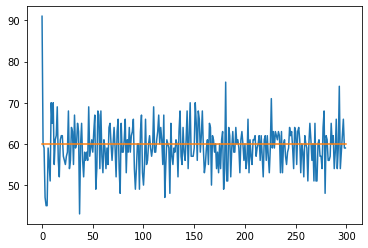

In [18]:
agents = 100
strategies = 5
memory = 8
threshold=60
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

It ran!

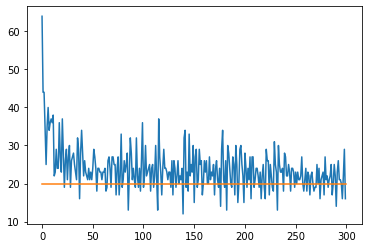

In [19]:
agents = 100
strategies = 5
memory = 8
threshold=20
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

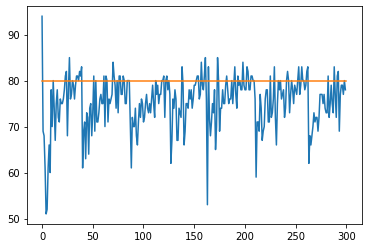

In [20]:
agents = 100
strategies = 5
memory = 8
threshold=80
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

In [16]:
sim.best_strats.keys()

dict_keys([8, 5, 3, 7, 10, 12, 19, 13, 6, 2, 18, 15, 17, 14, 11, 16, 4, 9])

Let's track some more things to get a better sense of what is happening.

What is the distribution of memory and strategies at each timestep.  Does it stabilize over time or keep changing?

In [96]:
class EFBPSim:
    def __init__(
        self,
        agents = 100, # number of agents
        threshold = 60, # threshold for attendance
        strategies = 10, # number of strategies
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 8,
        m_min=2,
        m_max=20,
        s_min=2,
        s_max=20,
        tol_rate = 0.5,
        tol_window=10,
        # number of rounds to run the simulation
        n_iter = 500,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # alternately, caller may pass a new strategy function
        strategy_func=None,
        # function for selecting the best strategy
        best_strat_func=minimize_squared_error,
        # starting history
        start=None,
        # file to write attendance history as it is generated
        writefile=None,
        # random seed for numpy
        seed=23
    ):
        
        rng = np.random.default_rng(seed)

        # each row is a strategy
        if not strategy_func:
            if distribution=="unbiased":
                strategy_func =  make_unbiased_strategies
            elif distribution=="uniform":
                strategy_func = make_uniform_strategies

        # shape is (agents, strategies,memory)
        strats = {
            memory: strategy_func(rng, strategies*agents, memory)
        }

        agent_indices = {
            memory: np.array([[i*strategies, (i+1) * strategies] for i in range(agents)])
        }

        if start is None:
            start = rng.choice(agents, size=(memory*2))

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)
            
        agent_went = {
            memory: np.zeros((agents, len(hist)))
        }
            
        # index of week
        # we need some starting history to begin making selections
        t = memory * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = {
            memory: np.zeros((agents, len(hist)), dtype=int)
        }

        # set up the predictions for initial history
        windows = np.vstack([
            hist[t-2*memory+i: t-memory + i]
            for i in range(memory)
        ])

        pred_history = {
            memory: np.zeros((agents * strategies, len(hist)))
        }
            
        pred_history[memory][:, memory:2*memory] = strats[memory].dot(windows)

        best_preds = {
            memory:np.zeros((agents, len(hist)))
        }
        
        # store the memory and strategies for each agent
        # at each timestep
        params = np.zeros((m_max+1, s_max+1, len(hist)))
 
        while t < memory * 2 + n_iter:
            
            for m in strats.keys():
                strat_counts = Counter()
                
                window = hist[t-m:t]
                
                try:
                    pred_history[m][:,t] = strats[m].dot(window)
                    
                except Exception as E:
                    assert False

                for agent, [i,j] in enumerate(agent_indices[m]):
                    strat_counts.update([j - i])
                    assert j-i < s_max
                    
                    strat = strats[m][i:j]

                    predictions = pred_history[m][i:j,t-m:t]
                    observations = hist[t-m:t]
                    
                    mask = ~np.isnan(predictions)
                    
                    # sanity check that all rows have same values
                    try:
                        assert (mask.any(axis=0) == mask.all(axis=0)).all()
                    except Exception as e:
                        print(i)
                        print(j)
                        print(predictions)
                        print(m)
                        print(mask)
                        raise e
                    
                    if (mask==False).all():
                        best_strat = 0
                    else:
                        # find first week with valid predictions
                        start_col = np.where(mask)[1][0]
                        best_strat = best_strat_func(rng, predictions[:, start_col:], observations[start_col:], threshold, j-i)
                        
                    best_strats[m][agent, t] = best_strat
                    best_preds[m][agent, t] = pred_history[m][i + best_strat, t]

                hist[t] += (best_preds[m] [:,t] < threshold).sum()
                
                for s, cnt in strat_counts.items():
                    params[m, s, t] = cnt
                
                
            # go back through and evaluate if the agent needs
            # to change parameters once we know the last attendance value
            ms = list(strats.keys())
            for m in ms:
                if t < 2 * memory + tol_window :
                    continue
                    
                optimal_choices = hist[t-tol_window:t] < threshold
                
                # iterate through agents in reverse order
                # so enumeration doesn't get messed up
                # when earlier agents are deleted.
                n_agents = len(agent_indices[m])
                
                # for agent in range(n_agents):
                for agent in range(-1, -n_agents, -1):
                    
                    # flip index back to the right direction
                    agent = n_agents + agent
                    
                    (i,j) = agent_indices[m][agent]
                    
                    # first check that the agent has been in this regime for long enough.
                    if np.isnan(best_preds[m][agent, t-tol_window]):
                        continue

                    attendance = best_preds[m][agent, t-tol_window:t] < threshold
                    
                    if (attendance == optimal_choices).mean() < tol_rate:
                        
                        new_m = rng.choice(m_max - m_min) + m_min
                        new_s = rng.choice(s_max - s_min) + s_min
                        
                        assert strats[m].shape[0] == pred_history[m].shape[0]                        

                        # delete old agent
                        strats[m] = np.vstack([
                            strats[m][:i],
                            strats[m][j:]
                        ])

                        pred_history[m] = np.vstack([
                            pred_history[m][:i],
                            pred_history[m][j:]
                        ])

                        # reindex later agents
                        if agent == len(agent_indices[m]) - 1:
                            agent_indices[m] = agent_indices[m][:-1]
                        else:
                            agent_indices[m] = np.vstack([
                                agent_indices[m][:agent],
                                agent_indices[m][agent+1:] - (j - i)
                            ])
                        try:
                            assert agent_indices[m].min() == 0
                        except:
                            print(agent_indices)
                            print(agent_indices[m].min())
                            assert False

                        best_preds[m] = np.vstack([
                            best_preds[m][:agent, :],
                            best_preds[m][agent+1:,:]
                        ])
                        
                        best_strats[m] = np.vstack([
                            best_strats[m][:agent, :],
                            best_strats[m][agent+1:,:]
                        ])

                        # add new strategies where appropriate
                        strats[new_m] = np.vstack([
                            strats.get(new_m, np.zeros((0, new_m))),
                            strategy_func(rng, new_s, new_m)
                        ])
                        
                        pred_history[new_m] = np.vstack([
                            pred_history.get(new_m, np.zeros((0, len(hist)))),
                            np.full((new_s,len(hist)), np.nan)
                        ])

                        if new_m in agent_indices:
                            new_i = agent_indices[new_m].max()
                            new_j = new_i + new_s
                            agent_indices[new_m] = np.vstack([
                                agent_indices[new_m],
                                np.array([new_i, new_j])
                            ])
                        else:
                            new_i = 0
                            new_j = new_s
                            agent_indices[new_m] = np.array([[0, new_s]])

                        # best preds get reset when agent changes strategy
                        new_best_preds = np.full((1,len(hist)), np.nan)

                        if new_m in best_preds:
                            best_preds[new_m] = np.vstack([
                                best_preds[new_m],
                                new_best_preds
                            ])
                            best_strats[new_m] = np.vstack([
                                best_strats[new_m],
                                new_best_preds
                            ])
 
                        else:
                            best_preds[new_m] = new_best_preds
                            best_strats[new_m] = new_best_preds
                            

            if writefile:
                with open(writefile, "a") as f:
                    f.write(str(hist[t]) + ",")

            t += 1
    
        self.t = t
        self.hist = hist[2*memory:t]
        self.best_strats = best_strats
        self.pred_history = pred_history
        self.strats = strats
        self.params = params[:, :, 2*memory:t]

    def first_a(self):
        return [self.strats[i][int(s), 0] for i, s in enumerate(self.best_strats)]
    
    def jth_a(self, j):
        return [self.strats[i][int(s), j] for i, s in enumerate(self.best_strats)]

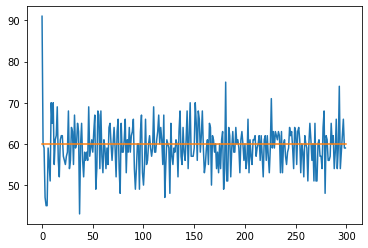

In [97]:
agents = 100
strategies = 5
memory = 8
threshold=60
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

In [109]:
import seaborn as sns

<AxesSubplot:>

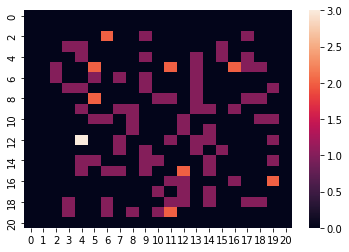

In [111]:
sns.heatmap(sim.params[:, :, 50])

<AxesSubplot:>

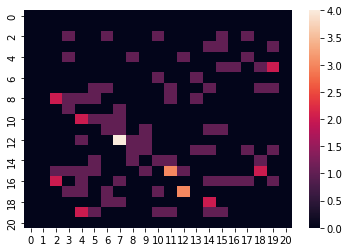

In [112]:
sns.heatmap(sim.params[:, :, 100])

<AxesSubplot:>

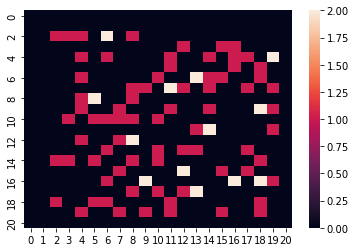

In [113]:
sns.heatmap(sim.params[:, :, 200])

<AxesSubplot:>

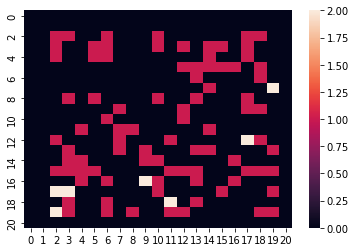

In [115]:
sns.heatmap(sim.params[:, :, 299])

<AxesSubplot:>

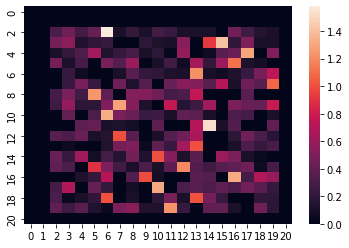

In [118]:
sns.heatmap(sim.params[:, :, 200:].mean(axis=2))

<AxesSubplot:>

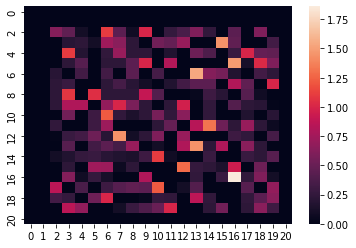

In [120]:
sns.heatmap(sim.params[:, :, 150:200].mean(axis=2))

Are there meamningful patterns here?  It's hard to tell.

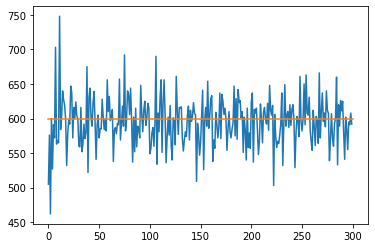

In [134]:
agents = 1000
strategies = 5
memory = 8
threshold=0.6 * agents
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

<AxesSubplot:>

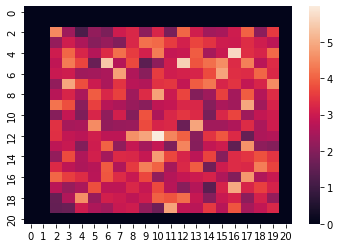

In [135]:
sns.heatmap(sim.params[:, :, 200:].mean(axis=2))

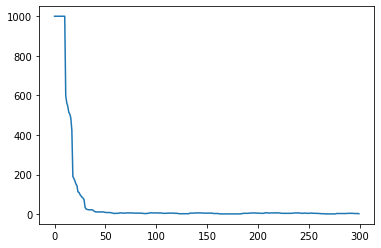

In [136]:
plt.plot(sim.params[memory, strategies, :])

<AxesSubplot:>

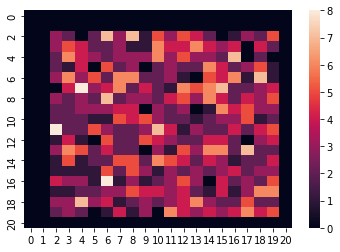

In [137]:
sns.heatmap(sim.params[:, :, -1])

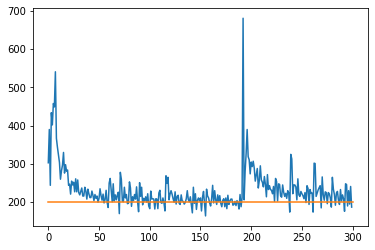

In [138]:
agents = 1000
strategies = 5
memory = 8
threshold=0.2 * agents
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

<AxesSubplot:>

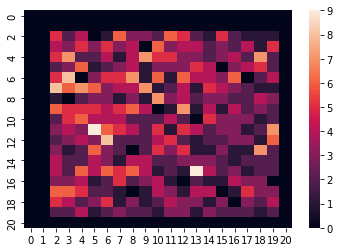

In [139]:
sns.heatmap(sim.params[:, :, -1])

<AxesSubplot:>

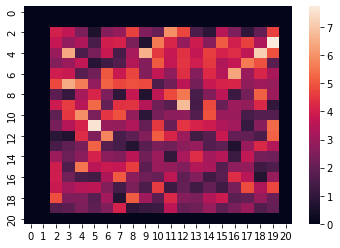

In [140]:
sns.heatmap(sim.params[:, :, 200:].mean(axis=2))

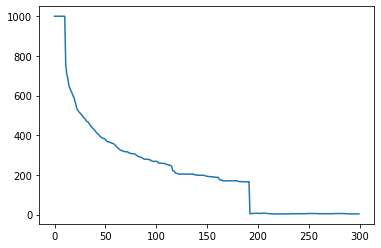

In [141]:
plt.plot(sim.params[memory, strategies, :])

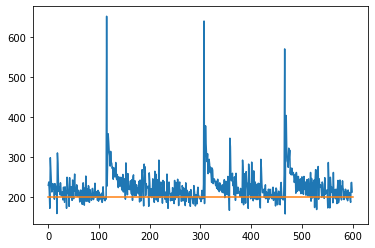

In [143]:
agents = 1000
strategies = 5
memory = 8
threshold=0.2 * agents
n_iter = 1200
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist[600:])
plt.plot([0, n_iter-600], [threshold, threshold])

<AxesSubplot:>

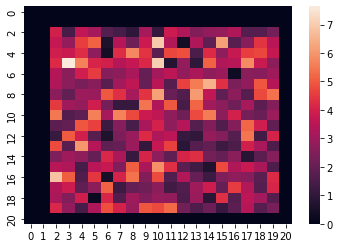

In [147]:
sns.heatmap(sim.params[:, :, -100:].mean(axis=2))

<AxesSubplot:>

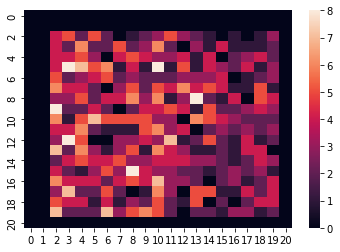

In [144]:
sns.heatmap(sim.params[:, :, -1])

<AxesSubplot:>

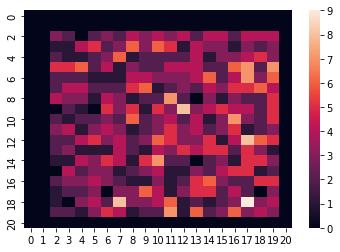

In [145]:
sns.heatmap(sim.params[:, :, 400])

<AxesSubplot:>

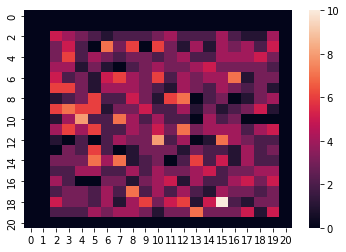

In [146]:
sns.heatmap(sim.params[:, :, 200])

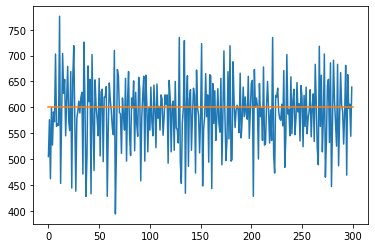

In [148]:
agents = 1000
strategies = 5
memory = 8
threshold=0.6 * agents
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    s_min=20,
    s_max=50,
    m_min=2,
    m_max=10,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

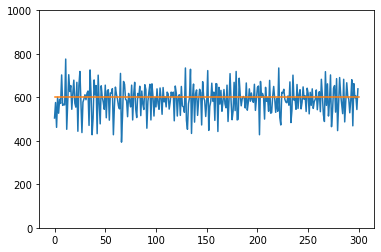

In [149]:
plt.plot(sim.hist)
plt.ylim([0,1000])
plt.plot([0, n_iter], [threshold, threshold])

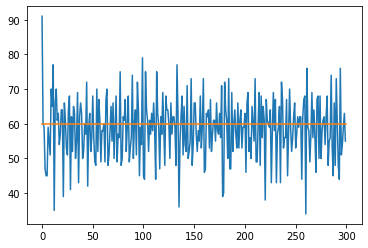

In [150]:
agents = 100
strategies = 5
memory = 8
threshold=0.6 * agents
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    s_min=20,
    s_max=50,
    m_min=2,
    m_max=10,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.plot([0, n_iter], [threshold, threshold])

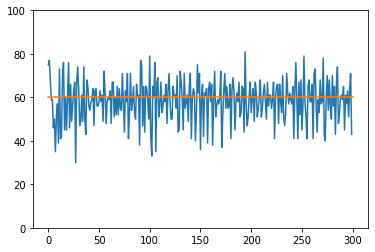

In [152]:
agents = 100
strategies = 10
memory = 10
threshold=0.6 * agents
n_iter = 300
seed = 1

sim = EFBPSim(
    agents=agents,
    strategies=strategies,
    memory=memory,
    threshold=threshold,
    n_iter=n_iter,
    s_min=20,
    s_max=50,
    m_min=2,
    m_max=10,
    distribution="uniform",
    seed=seed)

plt.plot(sim.hist)
plt.ylim([0,100])
plt.plot([0, n_iter], [threshold, threshold])

In [153]:
sims = {0.6: sim}

In [154]:
for threshold in [0.2, 0.4, 0.8]:
    sims[threshold] = EFBPSim(
        agents=agents,
        strategies=strategies,
        memory=memory,
        threshold=threshold*agents,
        n_iter=n_iter,
        s_min=20,
        s_max=50,
        m_min=2,
        m_max=10,
        distribution="uniform",
        seed=seed)

Text(0.5, 1.0, 't=80')

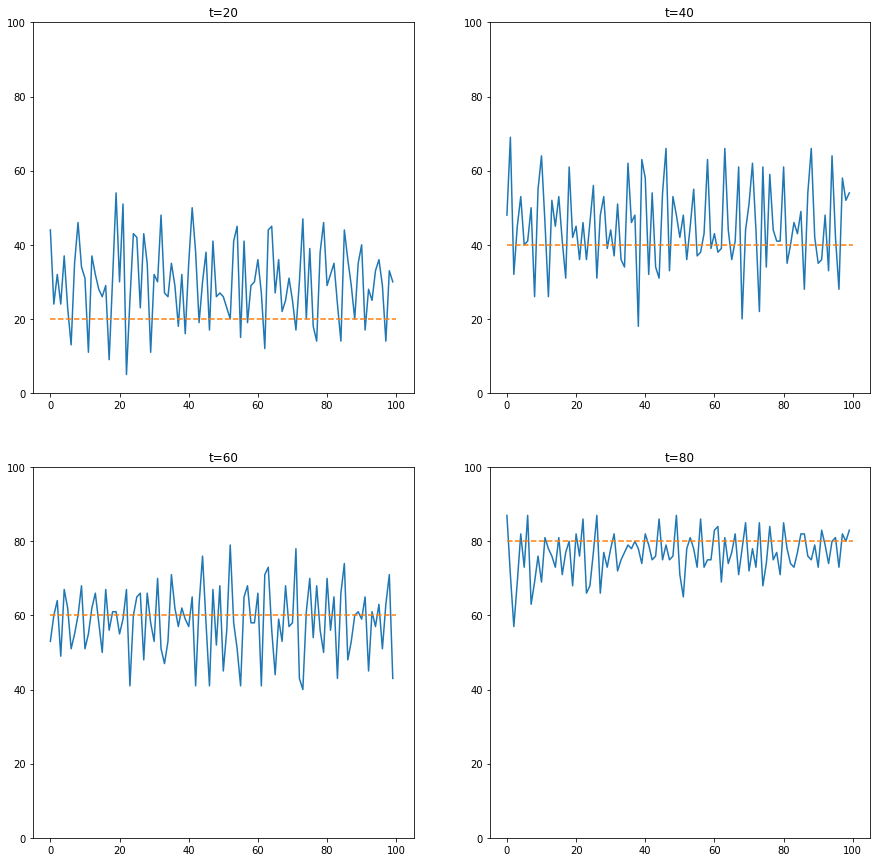

In [160]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].plot(sims[0.2].hist[-100:])
ax[0,0].plot([0,100], [20,20], "--")
ax[0,0].set_ylim([0,100])
ax[0,0].set_title("t=20")

ax[0,1].plot(sims[0.4].hist[-100:])
ax[0,1].plot([0,100], [40,40], "--")
ax[0,1].set_ylim([0,100])
ax[0,1].set_title("t=40")

ax[1,0].plot(sims[0.6].hist[-100:])
ax[1,0].plot([0,100], [60,60], "--")
ax[1,0].set_ylim([0,100])
ax[1,0].set_title("t=60")

ax[1,1].plot(sims[0.8].hist[-100:])
ax[1,1].plot([0,100], [80,80], "--")
ax[1,1].set_ylim([0,100])
ax[1,1].set_title("t=80")

In [165]:
agents = 100
m = 10
s = 100
n_iter = 100

h = rng.choice(agents + 1, size=2*m)

for threshold in [0.2, 0.4,0.6, 0.8]:
    sims[threshold] = EFBPSim(
        agents=agents,
        strategies=s,
        memory=m,
        s_min=s,
        s_max=300,
        m_min=2,
        m_max=m,
        threshold=threshold*agents,
        n_iter=n_iter,
        distribution="uniform",
        seed=rng.choice(99999))

Text(0.5, 1.0, 't=80')

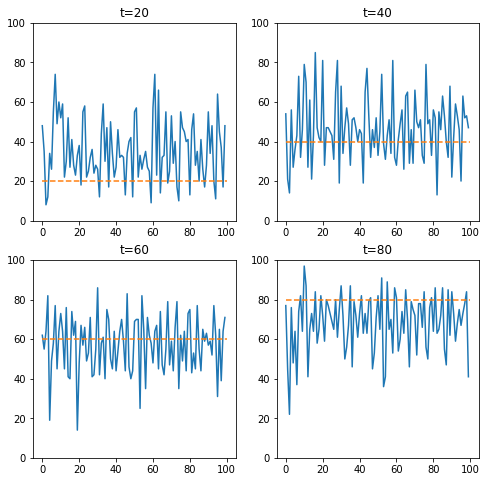

In [167]:
fig, ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].plot(sims[0.2].hist[-100:])
ax[0,0].plot([0,100], [20,20], "--")
ax[0,0].set_ylim([0,100])
ax[0,0].set_title("t=20")

ax[0,1].plot(sims[0.4].hist[-100:])
ax[0,1].plot([0,100], [40,40], "--")
ax[0,1].set_ylim([0,100])
ax[0,1].set_title("t=40")

ax[1,0].plot(sims[0.6].hist[-100:])
ax[1,0].plot([0,100], [60,60], "--")
ax[1,0].set_ylim([0,100])
ax[1,0].set_title("t=60")

ax[1,1].plot(sims[0.8].hist[-100:])
ax[1,1].plot([0,100], [80,80], "--")
ax[1,1].set_ylim([0,100])
ax[1,1].set_title("t=80")

In [170]:
agents = 100
m = 10
s = 100
n_iter = 300

h = rng.choice(agents + 1, size=2*m)

for threshold in [0.2, 0.4,0.6, 0.8]:
    sims[threshold] = EFBPSim(
        agents=agents,
        strategies=s,
        memory=m,
        s_min=s//2,
        s_max=s + s//2,
        m_min=m//2,
        m_max=m+m//2,
        threshold=threshold*agents,
        n_iter=n_iter,
        distribution="uniform",
        seed=rng.choice(99999))

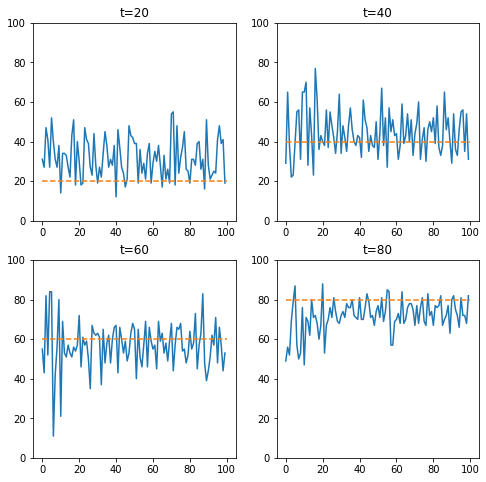

In [173]:
fig, ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].plot(sims[0.2].hist[:100])
ax[0,0].plot([0,100], [20,20], "--")
ax[0,0].set_ylim([0,100])
ax[0,0].set_title("t=20")

ax[0,1].plot(sims[0.4].hist[:100])
ax[0,1].plot([0,100], [40,40], "--")
ax[0,1].set_ylim([0,100])
ax[0,1].set_title("t=40")

ax[1,0].plot(sims[0.6].hist[:100])
ax[1,0].plot([0,100], [60,60], "--")
ax[1,0].set_ylim([0,100])
ax[1,0].set_title("t=60")

ax[1,1].plot(sims[0.8].hist[:100])
ax[1,1].plot([0,100], [80,80], "--")
ax[1,1].set_ylim([0,100])
ax[1,1].set_title("t=80")

plt.savefig("with_evoluion.png")

<AxesSubplot:>

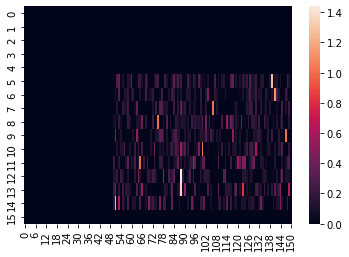

In [175]:
sns.heatmap(sims[0.6].params[:, :, -100:].mean(axis=2))

In [183]:
(sims[0.6].params[:, :, -1].sum(axis=0) * np.arange(151)).mean()

65.74172185430463

In [185]:
(sims[0.6].params[:, :, -1].sum(axis=1) * np.arange(16)).mean()

58.25

In [187]:
np.arange(16).dot(sims[0.6].params[:, :, -1]).mean()

6.172185430463577

In [188]:
(sims[0.6].params[:, :, -1]).dot(np.arange(151)).mean()

620.4375

In [191]:
np.arange(151).dot(sims[0.6].params[:, :, -1].T).mean()

620.4375

In [192]:
sims[0.6].params[:, :, -1].sum()

100.0

In [208]:
s = 0
for i in range(5, 15):
    s+= sims[0.6].params[:, :, -1][i].sum()

In [210]:
s

100.0

In [211]:
agents = 100
m = 10
s = 100
n_iter = 300

h = rng.choice(agents + 1, size=2*m)

for threshold in [0.2, 0.4,0.6, 0.8]:
    sims[threshold] = EFBPSim(
        agents=agents,
        strategies=s,
        memory=m,
        s_min=s//2,
        s_max=s + s//2,
        m_min=m//2,
        m_max=m+m//2,
        tol_rate=0.8,
        threshold=threshold*agents,
        n_iter=n_iter,
        distribution="uniform",
        seed=rng.choice(99999))

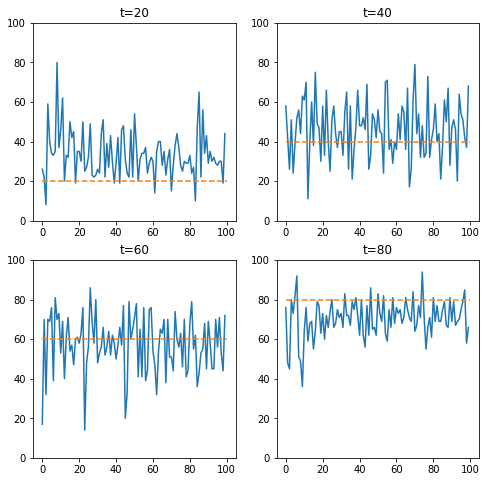

In [212]:
fig, ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].plot(sims[0.2].hist[:100])
ax[0,0].plot([0,100], [20,20], "--")
ax[0,0].set_ylim([0,100])
ax[0,0].set_title("t=20")

ax[0,1].plot(sims[0.4].hist[:100])
ax[0,1].plot([0,100], [40,40], "--")
ax[0,1].set_ylim([0,100])
ax[0,1].set_title("t=40")

ax[1,0].plot(sims[0.6].hist[:100])
ax[1,0].plot([0,100], [60,60], "--")
ax[1,0].set_ylim([0,100])
ax[1,0].set_title("t=60")

ax[1,1].plot(sims[0.8].hist[:100])
ax[1,1].plot([0,100], [80,80], "--")
ax[1,1].set_ylim([0,100])
ax[1,1].set_title("t=80")

plt.savefig("with_evoluion.png")